<a href="https://colab.research.google.com/github/DURUII/DURUII/blob/main/tutorial/feature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scienceplots python_speech_features black[jupyter]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 KB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 61.9 MB/s eta 0:00:00
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5889 sha256=4c3c90357dbe8e138bd0d308ee7b06b137706f83a3b830890604fb98f798f1cd
  Stored in directory: /root/.cache/pip/wheels/5b/60/87/28af2605138deac93d162904df42b6fdda1dab9b8757c62aa3
Successfully built python_speech_features
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the fol

In [ ]:
import torch
import torchaudio
import librosa
import scipy.io.wavfile as sciwav
import soundfile
import numpy as np
import random

import matplotlib.pyplot as plt
import scienceplots

plt.style.use(["grid", "science", "notebook"])

from IPython.display import Audio, display

import os

root_path = "./"

In [ ]:
from google.colab import drive

drive.mount("/content/drive", force_remount=True)
root_path = "drive/MyDrive/speaker-verification"
!ls drive/MyDrive

torchaudio.set_audio_backend("sox_io")
print(torchaudio.__version__, torchaudio.get_audio_backend())

Mounted at /content/drive
'Colab Notebooks'	     'Untitled document.gdoc'
'Flash cards.gslides'	     'Untitled presentation.gslides'
'Saved translations.gsheet'  '无标题文档 (1).gdoc'
 speaker-verification	      无标题文档.gdoc
0.13.0+cu116 sox_io


In [ ]:
# for reproducity
def same_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

In [ ]:
audio_path = os.path.join(root_path, "res/Imposter.wav")
metadata = torchaudio.info(audio_path)
print(metadata)

AudioMetaData(sample_rate=48000, num_frames=307200, num_channels=1, bits_per_sample=16, encoding=PCM_S)


#  Load
- librosa
- scipy
- soundfile
- torchaudio

In [ ]:
signal_librosa, sr = librosa.load(path=audio_path, sr=None)
print(signal_librosa.shape, sr, signal_librosa.dtype, sep="\n")

(307200,)
48000
float32


In [ ]:
sr, signal_sciwav = sciwav.read(filename=audio_path)
print(signal_sciwav.shape, sr, signal_sciwav.dtype, sep="\n")

(307200,)
48000
int16


In [ ]:
signal_soundfile, sr = soundfile.read(file=audio_path)
print(signal_soundfile.shape, sr, signal_soundfile.dtype, sep="\n")

(307200,)
48000
float64


In [ ]:
print(torchaudio.__version__, torchaudio.get_audio_backend())
signal_torchaudio, sr = torchaudio.load(audio_path)
print(signal_torchaudio.shape, sr, signal_soundfile.dtype, sep="\n")

0.13.0+cu116 sox_io
torch.Size([1, 307200])
48000
float64


# Peep

In [ ]:
display(Audio(signal_torchaudio.numpy()[0], rate=sr))

/usr/local/lib/python3.8/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


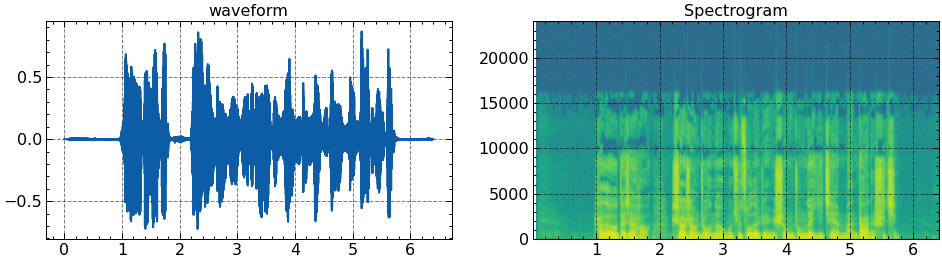

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

ax = axes[0]
num_frames = signal_torchaudio.shape[1]
time_axis = torch.arange(0, num_frames) / sr
ax.plot(time_axis, signal_torchaudio.numpy()[0])
ax.set_title("waveform")

ax = axes[1]
ax.specgram(signal_torchaudio.numpy()[0], Fs=sr)
ax.set_title("Spectrogram")

plt.show()

# Audio Augumentation
## waveform

MUSAN: http://openslr.org/17/

RIR:   http://openslr.org/28/

In [ ]:
def my_transform(audio_torchaudio, orig_freq, noise_torchaudio, new_freq):
    # 重采样
    resample = torchaudio.transforms.Resample(orig_freq, new_freq)
    audio_torchaudio = resample(audio_torchaudio)

    # 固定长度
    speech = audio_torchaudio
    noise = noise_torchaudio
    min_frames = min(speech.shape[1], noise.shape[1])
    speech = speech[0, :min_frames]
    noise = noise[0, :min_frames]

    return speech, noise


print(torchaudio.info(audio_path))
audio_torchaudio, orig_freq = torchaudio.load(audio_path)
display(Audio(audio_torchaudio.numpy()[0], rate=orig_freq))

AudioMetaData(sample_rate=48000, num_frames=307200, num_channels=1, bits_per_sample=16, encoding=PCM_S)


### Energy

```shell
rundll32 sysdm.cpl,EditEnvironmentVariables
```

https://sox.sourceforge.net/
http://sox.sourceforge.net/sox.html

In [ ]:
# !apt-get install sox
!sox --i {audio_path}

/bin/bash: sox: command not found


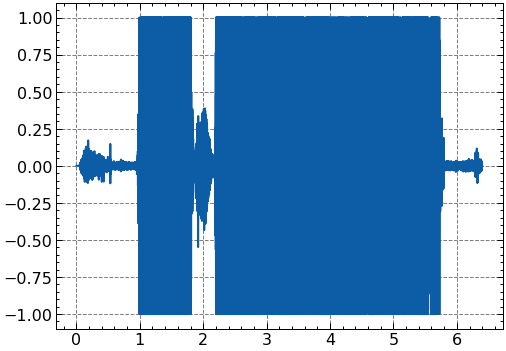

In [ ]:
same_seed(20021120)
value = str(random.random() * 15 + 5)
effects = [["vol", value]]
signal_sox, sample_rate = torchaudio.sox_effects.apply_effects_tensor(
    audio_torchaudio, orig_freq, effects, channels_first=True
)

display(Audio(signal_sox.numpy()[0], rate=sample_rate))
plt.plot(torch.arange(0, signal_sox.shape[1]) / sample_rate, signal_sox.numpy()[0])
plt.show()

### Tempo

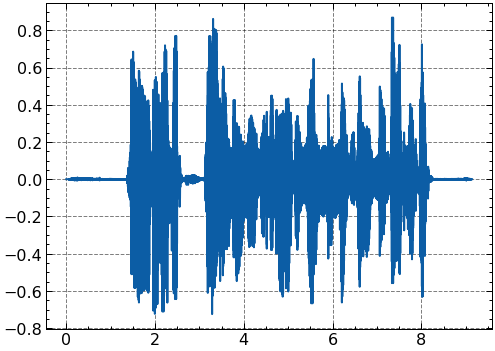

In [ ]:
value = random.choice([0.7, 1.3])
effects = [["tempo", str(value)]]

signal_sox, sample_rate = torchaudio.sox_effects.apply_effects_tensor(
    audio_torchaudio, orig_freq, effects, channels_first=True
)

display(Audio(signal_sox.numpy()[0], rate=sample_rate))
plt.plot(torch.arange(0, signal_sox.shape[1]) / sample_rate, signal_sox.numpy()[0])
plt.show()

### Pitch/Speed

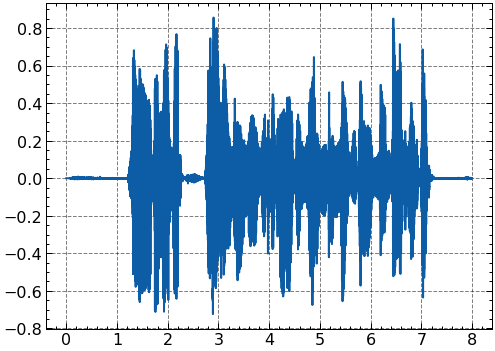

In [ ]:
value = [0.8, 1.1]
effects = [["speed", str(value[0])], ["rate", str(16000)]]

signal_sox, sample_rate = torchaudio.sox_effects.apply_effects_tensor(
    audio_torchaudio, orig_freq, effects, channels_first=True
)

display(Audio(signal_sox.numpy()[0], rate=sample_rate))
plt.plot(torch.arange(0, signal_sox.shape[1]) / sample_rate, signal_sox.numpy()[0])
plt.show()

### *Reverberation

问题：去混响是去除加性噪声还是乘性噪声？
答案：乘性噪声

讨论：语音+噪声+混响？语音+混响+噪声？语音+混响+（噪声+混响）？

In [ ]:
from scipy import signal as scisignal

audio_path = os.path.join(root_path, "res/Imposter.wav")
aw, asr = torchaudio.load(audio_path)
rir_path = audio_path = os.path.join(root_path, "res/RIRS_NOISES/largeroom.wav")
nw, nsr = torchaudio.load(rir_path)

speech, noise = my_transform(aw, asr, nw, nsr)
noisy_speech = scisignal.convolve(speech, noise, mode="full")

display(Audio(noisy_speech, rate=nsr))

### *Noise
信噪比，即SNR（Signal to Noise Ratio）又称为讯噪比，即放大器的输出信号的电压与同时输出的噪声电压的比，常常用分贝数表示。设备的信噪比越高表明它产生的杂音越少。一般来说，信噪比越大，说明混在信号里的噪声越小，声音回放的音质量越高，否则相反。信噪比一般不应该低于 70dB，高保真音箱的信噪比应达到110dB以上.

<br>

$SNR = \frac{P_{signal}}{P_{noise}}$

<br>

$SNR_{dB} = 10log_{10}SNR$

In [ ]:
audio_path = os.path.join(root_path, "res/Imposter.wav")
print(torchaudio.info(audio_path))
audio_torchaudio, orig_freq = torchaudio.load(audio_path)
display(Audio(audio_torchaudio.numpy()[0], rate=orig_freq))

noise_path = audio_path = os.path.join(root_path, "res/musan/noise.wav")
print(torchaudio.info(noise_path))
noise_torchaudio, new_freq = torchaudio.load(noise_path)
display(Audio(noise_torchaudio.numpy()[0], rate=new_freq))

speech, noise = my_transform(audio_torchaudio, orig_freq, noise_torchaudio, new_freq)

AudioMetaData(sample_rate=48000, num_frames=307200, num_channels=1, bits_per_sample=16, encoding=PCM_S)


AudioMetaData(sample_rate=16000, num_frames=107999, num_channels=1, bits_per_sample=16, encoding=PCM_S)


In [ ]:
same_seed(20021118)

speech_power = speech.norm(p=2)
noise_power = noise.norm(p=2)
snr_dur = [0, 20]
snr_db = snr_dur[0] + (snr_dur[1] - snr_dur[0]) * random.random()
print("SNR_dB: ", snr_db)
snr = 10 ** (snr_db / 20)
scale = snr * noise_power / speech_power

noisy_speech = (scale * speech + noise) / 2

SNR_dB:  1.9544049081820636


/usr/local/lib/python3.8/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


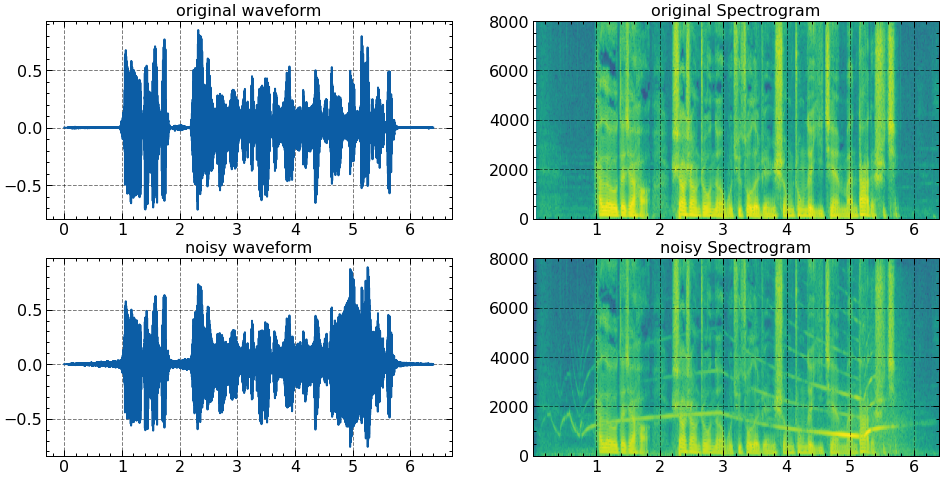

In [ ]:
display(Audio(noisy_speech.numpy(), rate=new_freq))
fig, axes = plt.subplots(2, 2, figsize=(16, 8))

ax = axes[0][0]
num_frames = speech.shape[0]
time_axis = torch.arange(0, num_frames) / new_freq
ax.plot(time_axis, speech.numpy())
ax.set_title("original waveform")

ax = axes[0][1]
ax.specgram(speech.numpy(), Fs=new_freq)
ax.set_title("original Spectrogram")

ax = axes[1][0]
num_frames = noisy_speech.shape[0]
time_axis = torch.arange(0, num_frames) / new_freq
ax.plot(time_axis, noisy_speech.numpy())
ax.set_title("noisy waveform")

ax = axes[1][1]
ax.specgram(noisy_speech.numpy(), Fs=new_freq)
ax.set_title("noisy Spectrogram")

plt.show()

# Feature Extraction

- torchaudio
- python_speech_feature
- kaldi
- librosa

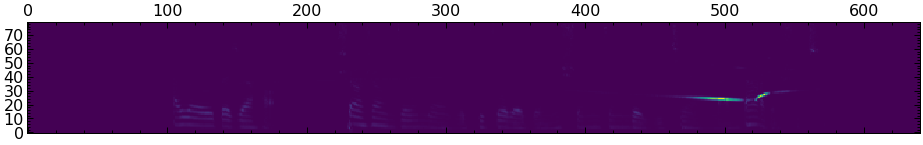

In [ ]:
from python_speech_features import sigproc

signal = noisy_speech
signal_pre = sigproc.preemphasis(signal, 0.97)

transforms = torchaudio.transforms.MelSpectrogram(
    sample_rate=16000,
    n_fft=512,
    win_length=int(16000 * 0.025),
    hop_length=int(16000 * 0.010),
    n_mels=80,
)

fbank = transforms(signal)
plt.matshow(fbank, origin="lower")
plt.grid(False)

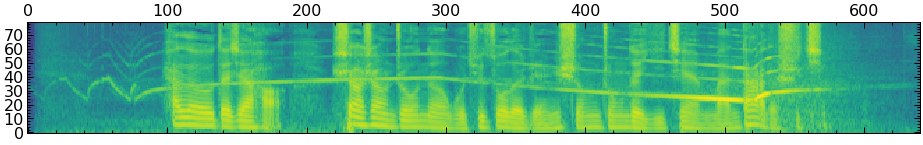

In [ ]:
log_fbank = torch.log(fbank)
plt.matshow(log_fbank, origin="lower")
plt.grid(False)

# Feature Augmentation

## SpecAug

https://readpaper.com/paper/2936774411

In [ ]:
import torchaudio.transforms as T

type = random.sample(["time", "freq"], 1)[0]
print(type)

freq


In [ ]:
if type == "time":
    masking = T.TimeMasking(time_mask_param=random.randint(0, 10))
else:
    masking = T.FrequencyMasking(freq_mask_param=random.randint(0, 5))

feats_masked = masking(log_fbank)

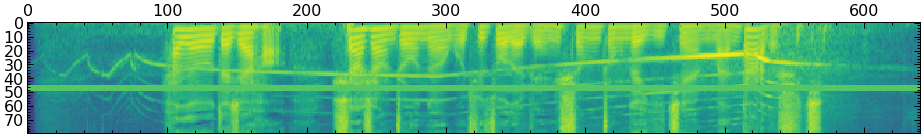

In [ ]:
plt.matshow(feats_masked)
plt.grid(False)

In [29]:
!black drive/MyDrive/Colab\ Notebooks/feature.ipynb

All done! ✨ 🍰 ✨
1 file left unchanged.
